In [208]:
import pandas as pd
import numpy as np
import itertools
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from tqdm import tqdm
import time
import gc

In [209]:
def calcGeomAvg(returns: np.array,
    annualized: bool=False,
    periods_in_year: int=None) -> float: 
    """ Calculate the geometric average of a vector of simple returns.

    Args:
        returns (np.array): vector of a simple returns at any frequency.
        annualized (bool): whether to annualize the statistic.
        periods_in_year (int): how many periods of the given frequency are in a year.

    Returns:
        (float): scalar geometric average.
    """
    if not isinstance(returns, np.ndarray):
        raise TypeError("Input 'returns' must be a NumPy array")
    if annualized and periods_in_year is None:
        raise ValueError("Input 'periods_in_year' must be provided if 'annualized' is True")
    geom_avg_at_given_freq = np.prod(1 + returns) ** (1 / np.size(returns)) - 1
    return (geom_avg_at_given_freq + 1) ** periods_in_year - 1 if annualized else geom_avg_at_given_freq

def calcTSAvgReturn(returns: np.array,
    annualized: bool=False,
    periods_in_year: int=None) -> float:
    """ Calculate the time series mean return of a vector of simple returns with option to annualize.

    Args:
        returns (np.array): vector of a simple returns at any frequency.
        annualized (bool): whether to annualize the statistic.
        periods_in_year (int): how many periods of the given frequency are in a year.

    Returns:
        (float): scalar time series mean return.
    """
    mean_ret_at_given_freq = np.mean(returns)
    if annualized == False:
        return mean_ret_at_given_freq
    else:
        mean_ret = periods_in_year*mean_ret_at_given_freq
        if mean_ret < -1:
            return -1.
        else:
            return mean_ret

def calcTotalReturn(returns: np.array,
    annualized: bool=False,
    periods_in_year: int=None) -> float:
    """ Calculate the total return of a vector of simple returns with option to annualize.

    Args:
        returns (np.array): vector of a simple returns at any frequency.
        annualized (bool): whether to annualize the statistic.
        periods_in_year (int): how many periods of the given frequency are in a year.

    Returns:
        (float): scalar total return.
    """
    total_return = np.prod(1+returns)-1
    if annualized==False:
        return total_return
    else:
        return (total_return+1)**(periods_in_year/len(returns))-1

def calcSD(returns: np.array,
    annualized: bool=False,
    periods_in_year: int=None) -> float: 
    """ Calculate the standard deviation of a vector of simple returns with option to annualize.

    Args:
        returns (np.array): vector of a simple returns at any frequency.
        annualized (bool): whether to annualize the statistic.
        periods_in_year (int): how many periods of the given frequency are in a year.

    Returns:
        (float): scalar standard deviation.
    """
    sd_at_given_freq = np.std(returns)
    if annualized==False:
        return sd_at_given_freq
    else:
        return np.sqrt(periods_in_year)*sd_at_given_freq

def calcSharpe(returns: np.array,
    periods_in_year: int,
    risk_free_returns: np.array=None) -> float:
    """ Calculate the annual Sharpe Ratio of a vector of simple returns. 

    Args:
        returns (np.array): vector of a simple returns at any frequency.
        periods_in_year (int): how many periods of the given frequency are in a year.
        risk_free_returns (np.array): vector of simple returns of the risk free rate.

    Returns:
        (float): scalar standard deviation.
    """
    if risk_free_returns is not None:
        returns = returns - risk_free_returns
    
    return (calcTSAvgReturn(returns, annualized=True, periods_in_year=periods_in_year) /
            calcSD(returns, annualized=True, periods_in_year=periods_in_year))

def calcMaxDrawdown(returns: np.array) -> float:
    ''' calculate maximum drawdown for a vector of returns of any frequency.
    
    Args:
        returns (np.array): vector of simple returns.
    
    Returns:
        max_drawdown (float): maximum drawdown in simple return units over this period.
    '''
    # calculate the cumulative return as a new vector of the same length
    cumulative_ret=(returns+1).cumprod()

    # for every period, calc the historic maximum value of the portfolio 
    roll_max=pd.Series(cumulative_ret).rolling(len(cumulative_ret), min_periods=1).max()

    # calc drawdown as the current portfolio value divided by the historic max value
    dd=np.min(cumulative_ret/roll_max)
    
    # return simple return of max drawdown
    return dd-1

def calcMaxOneWeekLoss(returns: np.array, periods_in_week: int) -> float:
    ''' Calculate the maximum loss for a one week period given how many obs are in week for input
        returns.
    
    Args:
        returns (np.array): vector of simple returns of any frequency.
        periods_in_week (int): number of observations in a week.
    
    Returns:
        max_loss (float): maximum loss over any one week period in simple returns.
    '''
    weekly_returns = (pd.Series(returns)+1).rolling(periods_in_week).apply(np.prod)
    max_loss = weekly_returns.min()-1
    return max_loss

def calcTransactionCosts(positions: np.array) -> np.array:
    ''' Calculate a vector of transaction costs which are positive numbers in return units.
    
    Args:
        positions (np.array): vector of positions, where positive is long and above 1, in absolute
                              value terms, is a leveraged position.

    Returns:
        tc (np.array): vector of transaction costs in return terms.
    '''
    # transaction costs, in return terms, from kraken for trading two spots paris, on margin
    tc_to_open        = 0.0010
    tc_to_close       = 0.0010
    tc_to_open_margin = 0.00015
    tc_margin_2_d     = 0.0024

    # initial tc array
    tc = np.zeros(len(positions))

    # set first tc
    first_position = positions[0]
    if first_position == 0:
        tc[0] = 0
    elif (-1 <= first_position) & (first_position <= 1):
        tc[0] = tc_to_open
    elif (-5 <= first_position) & (first_position <= 5):
        tc[0] = tc_to_open+tc_to_open_margin+tc_margin_2_d
    else:
        raise ValueError('first position is not a valid position.')

    # set remaining tc's
    for i in range(1,len(tc)):
        prev_position = positions[i-1]
        current_position = positions[i]
        if current_position == prev_position:
            if np.abs(current_position)>1:
                tc[i] = tc_margin_2_d
        else:
            if current_position==0:
                tc[i] = tc_to_close
            elif (-1 <= current_position) & (current_position <= 1):
                tc[i] = tc_to_close+tc_to_open
            elif (-5 <= current_position) & (current_position <= 5):
                tc[i] = tc_to_close+tc_to_open+tc_to_open_margin+tc_margin_2_d
            else: 
                raise ValueError('position '+str(i)+' is not a valid position.')

    # adjust last tc element for closing position
    last_position = positions[-1]
    if np.abs(last_position)>0:
        tc[-1] += tc_to_close

    return tc

In [210]:
def fitRF(train_df: pd.DataFrame,
    lhs_col: str,
    rhs_cols: list,
    hps: dict,
    ys_real: np.array) -> RandomForestClassifier: 
    ''' Fit random forest on given training data using RHS to predict LHS with given hps.

    Args:
        train_df (pd.DataFrame): training data.
        lhs_col (str): LHS column to predict.
        rhs_cols (list): list of strings of RHS features.
        hps (dict): key value pairs for hyperparameters to set including:
                    `num_estimators`, `subsample`, `min_samp_leaf`, `max_depth`, 
                    `max_feature`, `loss_func`, and `weight_func`.
        ys_real (np.array): vector of real valued lhs variable to use to weight.

    Returns:
        (RandomForestClassifier): fitted model.
    '''
    # obtain the rhs and lhs data
    train_rhs   = train_df[rhs_cols].values.astype('float32')
    train_lhs   = train_df[lhs_col].values.reshape(-1).astype('int')
    
    # build the model
    model = RandomForestClassifier(n_estimators=hps['num_estimator'],
        criterion=hps['loss_func'],
        max_depth=hps['max_depth'],
        min_samples_leaf=hps['min_samp_leaf'],
        max_features=hps['max_feature'],
        n_jobs=4,
        random_state=int(hps['num_estimator']
            *hps['subsample']
            *hps['min_samp_leaf']
            *hps['max_depth']
            *hps['max_feature']),
        class_weight=hps['class_balance'],
        max_samples=hps['subsample'])

    # calculate sample weights as linearly spaced from 0 to max value s.t. it sums to one
    num_samples = train_lhs.shape[0]
    if hps['weight_func'] == 'linear':
        weights = np.arange(0, num_samples)
        weights = weights/np.sum(weights)
        epsilon = weights[1]/2
        weights[0] = epsilon
        weights[-1] -= epsilon
    elif hps['weight_func'] == 'uniform':
        weights = np.ones(num_samples)/num_samples
    elif hps['weight_func'] == 'log':
        weights = np.log(np.arange(1,num_samples+1))
        weights = weights / np.sum(weights)
    elif hps['weight_func'] == 'exp':
        weights = np.arange(num_samples)**1.1
        weights = weights / np.sum(weights)
    elif hps['weight_func'] == 'y':
        weights = np.abs(ys_real) / np.sum(np.abs(ys_real))
    elif hps['weight_func'] == None:
        weights = hps['weight_func']
    else:
        raise ValueError('the weights function must be set to linear, uniform, log, or exp.')

    # fit
    model.fit(X=train_rhs, 
        y=train_lhs, 
        sample_weight=weights)

    # obtain training yhats and accuracy
    train_yhats = model.predict(train_rhs)
    train_acc = model.score(train_rhs, train_lhs)

    return model, train_acc, train_yhats

def genRFYhats(oos_df: pd.DataFrame, 
    model: RandomForestClassifier, 
    lhs_col: str, 
    rhs_cols: list) -> int: 
    """ Generate predicted probabilities for input data using a random forest classifier model.

    Args:
        oos_df (pd.DataFrame): out of sample data to fit on.
        model (RandomForestClassifier): trained random forest model.
        lhs_col (str): name of the column containing the label data.
        rhs_cols (list): column names containing the feature data.

    Returns:
        (int): predicted scalar class.
    """
    # obtain the RHS data
    oos_rhs   = oos_df[rhs_cols].values.astype('float32')
    
    # form the yhats
    yhat = model.predict(oos_rhs)
    
    # Return results
    return yhat[0]

In [211]:
def runCV(df: pd.DataFrame, 
    lhs_col: str,
    val_start_date: str,
    num_cpus: int,
    arch_name: str, 
    out_csv_fp: str) -> list:
    ''' run step-forward cross validation to select optimal hyperparameters for target model 
        returning fitting yhats and models as well as outputting results to csv.

    Args:
        df (pd.DataFrame): panel of training and val data with date index, LHS variable named 
                           `lhs_col`, and remaining cols are RHS features.
        lhs_col (str): name of the lhs target column.
        val_start_date (str): the first date for the validation period.
        val_end_date (str): the last date for the validation period.
        num_cpus (int): number of cpus to use when parallelizing.
        arch_name (str): name of architecture to use when saving intermitent results.
        out_csv_fp (str): filepath to output the csv file without `.csv' on end.
          
    Returns:
        (list): list of dictionaries for each hyperparameter fit where each list contains keys of:
                    `hps` is dict of hyperparameter combination,
                    `yhats` is an array of validation period yhats, and,
                    `models` is list of fitted models.  
    '''
    # initialize args
    val_dates = np.unique(df[val_start_date:].index.values)
    results_list = []
    csv_dict_list = []
    rhs_cols = list(df.columns.values)
    rhs_cols.remove(lhs_col)

    # initialize hp grid for gbdt
    num_estimators  = [30]
    subsamples      = [0.99]
    min_samp_leafs  = [2]
    max_depths      = [3]
    max_features    = [0.65]
    loss_funcs      = ['log_loss']
    weight_funcs    = ['y']
    class_balances  = ['balanced']
    ret_thresholds  = [0]

    # loop over all hp combos
    for hps in itertools.product(num_estimators,
                                 subsamples,
                                 min_samp_leafs,
                                 max_depths, 
                                 max_features,
                                 loss_funcs,
                                 weight_funcs,
                                 class_balances,
                                 ret_thresholds):
        # initialize args
        results_dict = {}
        results_dict['hps'] = {'num_estimator': hps[0],
            'subsample': hps[1],
            'min_samp_leaf': hps[2],
            'max_depth': hps[3],
            'max_feature': hps[4],
            'loss_func': hps[5],
            'weight_func': hps[6],
            'class_balance': hps[7],
            'ret_threshold': hps[8]}
        print(results_dict['hps'], '\n') # monitor progress

        # form lhs
        cv_df = df.copy()
        ret_threshold = results_dict['hps']['ret_threshold']
        cv_df.loc[cv_df[lhs_col] > ret_threshold, 'y'] = 1
        cv_df.loc[cv_df[lhs_col] < -ret_threshold, 'y'] = 0

        # save val period returns
        btc_eth_diff = cv_df[val_start_date:][lhs_col].values

        # fit model on all val dates
        tic = time.perf_counter()
        def loopOverValDates(val_date): # set up as a func to loop over
            # form train and val data
            train_df = cv_df[cv_df.index < val_date].copy()
            train_y_btc_eth_diff = train_df[lhs_col].values
            train_df = train_df.drop(lhs_col, axis=1)
            val_df   = cv_df[cv_df.index == val_date].copy()
            val_df   = val_df.drop(lhs_col, axis=1)

            # fit model and generate yhats for val week
            model, train_acc, train_yhats = fitRF(train_df, 'y', rhs_cols, hps=results_dict['hps'],
                                                  ys_real = train_y_btc_eth_diff)
            yhats = genRFYhats(val_df, model, 'y', rhs_cols)

            return yhats, model, train_acc, train_yhats

        val_results = Parallel(n_jobs=int(num_cpus/4))(delayed(loopOverValDates)(val_date) for val_date in tqdm(val_dates))

        # extract validation periods results
        yhats_list = []
        models_list = []
        train_acc_list = []
        train_yhats_list = []
        for t in range(len(val_results)):
            yhats_list.append(val_results[t][0])
            models_list.append(val_results[t][1])
            train_acc_list.append(val_results[t][2])
            train_yhats_list.append(val_results[t][3])
        yhats = np.array(yhats_list)*2-1
        ys    = cv_df[val_start_date:].y.values*2-1
        results_dict['yhats'] = yhats

        # save results to master result list    
        results_list.append(results_dict)

        # save results to csv to monitor during cv
        toc = time.perf_counter()
        csv_dict = results_dict['hps'].copy()
        del results_dict
        csv_dict['arch_name'] = arch_name
        csv_dict['val_start_date'] = val_start_date
        csv_dict['val_end_date'] = np.datetime_as_string(np.max(df.index.values))[:10]
        csv_dict['runtime_mins'] = round((toc - tic)/60, 0) 
        total_obs = 0
        total_yhat_long = 0
        total_yhat_short = 0
        for train_yhats in train_yhats_list:
            train_yhats = train_yhats*2 - 1
            total_obs += train_yhats.shape[0]
            total_yhat_long += np.sum(train_yhats==1)
            total_yhat_short += np.sum(train_yhats==-1)
        csv_dict['yhat_long_pct_train'] = total_yhat_long / total_obs
        csv_dict['yhat_short_pct_train'] = total_yhat_short / total_obs
        csv_dict['accuracy_train'] = np.mean(np.array(train_acc_list))
        csv_dict['yhat_long_pct'] = np.sum(yhats==1)/len(yhats)
        csv_dict['yhat_short_pct'] = np.sum(yhats==-1)/len(yhats)
        csv_dict['accuracy'] = np.sum(yhats == ys)/len(ys)
        tc = calcTransactionCosts(yhats)
        returns = yhats*btc_eth_diff - tc
        csv_dict['geom_mean'] = calcGeomAvg(returns)
        csv_dict['sharpe'] = calcSharpe(returns, periods_in_year=int(365/2))
        csv_dict['sd_ann'] = calcSD(returns, annualized=True, periods_in_year=int(365/2))
        csv_dict['ts_mean_ann'] = calcTSAvgReturn(returns, annualized=True, periods_in_year=int(365/2))
        for lev in [2, 3, 4, 5]:
            lev_yhats = yhats*lev
            lev_tc = calcTransactionCosts(lev_yhats)
            lev_returns = lev_yhats*btc_eth_diff - lev_tc 
            csv_dict['geom_mean_x'+str(lev)] = calcGeomAvg(lev_returns)
            csv_dict['sharpe_x'+str(lev)] = calcSharpe(lev_returns, periods_in_year=int(365/2))
            csv_dict['sd_ann_x'+str(lev)] = calcSD(lev_returns, annualized=True, periods_in_year=int(365/2))
            csv_dict['ts_mean_ann_x'+str(lev)] = calcTSAvgReturn(lev_returns, annualized=True, periods_in_year=int(365/2))
        csv_dict_list.append(csv_dict)
        results_df = pd.DataFrame(csv_dict_list)

        timestr = time.strftime("%Y%m%d_%H%M%S")
        fp = out_csv_fp+'_'+arch_name+'_'+timestr+'.csv'
        results_df.to_csv(fp, index=False)

        # output results to track
        print(csv_dict['runtime_mins'])
        print(f"accuracy: {csv_dict['accuracy']:.4f}")

        print('\n\n\n')
        gc.collect()

    return results_list

In [212]:
def plotYvsYhat(y: np.array, yhats: np.array):
    ''' plot average values of y against bins of yhat.

    Args:
        y (np.array): vector of target variable.
        yhats (np.array): vector of fitted values.
    '''
    # form data
    temp_df = pd.DataFrame(data={'y': y, 'yhat': yhats})

    # plot
    temp_df.groupby('yhat')['y'].mean().plot()

In [213]:
def selectOptimalBacktestedModel(cv_results: list,
    df: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    lhs_col: str) -> dict:
    ''' Select the optimal model for the cross validation exercise where we test out various
        leverage options to select max sharpe such that it has positive geom avg return.

    Args:
        cv_results (list): list of dictionaries of backtest results.
        df (pd.DataFrame): dataframe to use for studying model performance.
        start_date (str): start date of the out of sample period.
        end_date (str): end date of the out of sample period.
        lhs_col (str): return difference for instrument.
    
    Returns:
        opt_model_dict (dict): the optimal model's hyperparameters and associated yhats.    
    '''
    # initialize objects
    oos_df = df[start_date:end_date].copy()
    btc_eth_diff = oos_df[lhs_col].values
    max_sharpe = 0

    # study each model's results
    for results_dict in cv_results:
        # obtain model's yhats
        yhats = results_dict['yhats']

        # calc model performance for all leverages
        for lev in [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]:
            lev_yhats = yhats*lev
            lev_tc = calcTransactionCosts(lev_yhats)
            lev_returns = lev_yhats*btc_eth_diff - lev_tc 
            geom_mean = calcGeomAvg(lev_returns)
            sharpe = calcSharpe(lev_returns, periods_in_year=int(365/2))

            # save optimal model 
            if (geom_mean > 0) & (sharpe > max_sharpe):
                max_sharpe = sharpe
                opt_model_dict = results_dict['hps']
                opt_model_dict['lev'] = lev
                optimal_yhats = yhats

    # report optimal model statistics
    lev_yhats = opt_model_dict['lev']*optimal_yhats
    lev_tc = calcTransactionCosts(lev_yhats)
    lev_returns = lev_yhats*btc_eth_diff - lev_tc 
    geom_mean = calcGeomAvg(lev_returns)
    sharpe = calcSharpe(lev_returns, periods_in_year=int(365/2))
    print('The optimal model has the following hyperparameters: ')
    print(opt_model_dict)
    print(f"Geometric average 2 day return: {geom_mean:.6f}")
    print(f"Annualized Sharpe: {sharpe:.3f}")

    # report average return by yhat bin
    ret_threshold = opt_model_dict['ret_threshold']
    temp_df = oos_df[[lhs_col]].copy()
    temp_df.loc[temp_df[lhs_col] > ret_threshold, 'y'] = 1
    temp_df.loc[temp_df[lhs_col] < -ret_threshold, 'y'] = -1
    plotYvsYhat(y=temp_df.y.values, yhats=yhats)

    # save yhats and return
    opt_model_dict['yhats'] = optimal_yhats
    return opt_model_dict

In [214]:
def reportBootstrapTstat(yhats: np.array,
    y_real: np.array,
    possible_positions: list,
    bs_size: int=1000):
    ''' print out bootstrapped standard error and t stat to see if oos returns are stat sig.

    Args:
        yhats (np.array): vector of actual portfolio positions each period for my portfolio.
        y_real (np.array): vector of real return for instrument.
        possible_positions (list): vector of possible portfolio positions for bs ports to take.
        bs_size (int): number of bs samples to generate.
    '''
    # generate BS vectors of length periods selecting from possible_positions
    periods = len(y_real)
    portfolios_list = []
    for i in range(bs_size):
        np.random.seed(i)
        portfolios_list.append(np.random.choice(possible_positions, size=periods))

    # calc geom BS returns
    bs_returns_list = []
    for i in range(bs_size):
        lev_position = portfolios_list[i]
        lev_tc = calcTransactionCosts(lev_position)
        lev_returns = lev_position*y_real - lev_tc 
        geom_mean = calcGeomAvg(lev_returns)
        bs_returns_list.append(geom_mean)

    # calc bs standard error
    bs_se = np.std(bs_returns_list)

    # report standard errors
    my_tc = calcTransactionCosts(yhats)
    my_returns = yhats*y_real - my_tc
    geom_mean_me = calcGeomAvg(my_returns)
    print(f"my portfolio geom avg return: {geom_mean_me:.6f}")
    print(f"bootstrapped standard error is {bs_se:.6f}")
    print(f"t stat is: {geom_mean_me/bs_se:.2f}")

In [215]:
def predictTestPeriod(df: pd.DataFrame,
    lhs_col: str,
    test_start_date: str,
    test_end_date: str,
    opt_model_dict: dict,
    num_cpus: int) -> np.array:
    ''' predict for test period using backtested model.

    Args:
        df (pd.DataFrame): panel of training and test data with date index, LHS variable named 
                           `lhs_col`, and remaining cols are RHS features.
        lhs_col (str): name of the lhs target column.
        test_start_date (str): the first date for the test period.
        test_end_date (str): the last date for the test period.
        opt_model_dict (dict): hyperparameters for optimal backtested model.
        num_cpus (int): number of cpus to use when parallelizing.
    
    Returns:
        yhats (np.array): vector of yhat positions for entire test period.
    '''
    # form list of rhs col
    rhs_cols = list(df.columns.values)
    rhs_cols.remove(lhs_col)

    # form lhs for oos df
    oos_df = df.copy()
    ret_threshold = opt_model_dict['ret_threshold']
    oos_df.loc[oos_df[lhs_col] > ret_threshold, 'y'] = 1
    oos_df.loc[oos_df[lhs_col] < -ret_threshold, 'y'] = 0

    # form test dates to loop over
    test_dates = np.unique(oos_df[test_start_date:test_end_date].index.values)

    def loopOverTestDates(test_date):
        # form train and val data
        temp_df   = oos_df[oos_df.index <= test_date].copy()
        train_df  = temp_df[temp_df.index < test_date].copy()
        train_y_btc_eth_diff = train_df[lhs_col].values
        train_df  = train_df.drop(lhs_col, axis=1)
        test_df   = temp_df[temp_df.index == test_date].copy()
        test_df   = test_df.drop(lhs_col, axis=1)

        # fit and predict
        model, train_acc, train_yhats = fitRF(train_df, 'y', rhs_cols, 
                                            hps=opt_model_dict, 
                                            ys_real=train_y_btc_eth_diff)
        yhats = genRFYhats(test_df, model, 'y', rhs_cols)

        return yhats, model, train_acc, train_yhats

    # predict for entire test period
    test_results = Parallel(n_jobs=int(num_cpus/4))(delayed(loopOverTestDates)(test_date) for test_date in tqdm(test_dates))

    # extract test yhats to return
    yhats_list = []
    for t in range(len(test_results)):
        yhats_list.append(test_results[t][0])
    yhats = np.array(yhats_list)*2-1

    return yhats

In [216]:
def reportTestPeriodResults(yhats: np.array, y_real: np.array):
    ''' report various portfolio statistics for the test period.
    
    Args:
        yhats (np.array): vector of actual portfolio positions.
        y_real (np.array): vector of real return difference for target instrument.
    '''
    # calculate returns post transaction costs
    tc = calcTransactionCosts(yhats)
    returns = yhats*y_real - tc
    
    # calc portfolio statistics
    geom_mean = calcGeomAvg(returns)
    sharpe    = calcSharpe(returns, periods_in_year=int(365/2))
    max_dd    = calcMaxDrawdown(returns)
    max_1week = calcMaxOneWeekLoss(returns, periods_in_week=3)

    # report
    print(f"Geometric average 2 day return: {geom_mean:.6f}")
    print(f"Annualized Sharpe: {sharpe:.3f}")
    print(f"Maximum drawdown: {max_dd:.4f}")
    print(f"Maximum loss over any one week period: {max_1week:.4f}")

    # plot classification
    plotYvsYhat(y=y_real, yhats=yhats)

{'num_estimator': 30, 'subsample': 0.99, 'min_samp_leaf': 2, 'max_depth': 3, 'max_feature': 0.65, 'loss_func': 'log_loss', 'weight_func': 'y', 'class_balance': 'balanced', 'ret_threshold': 0} 



100%|██████████| 137/137 [00:05<00:00, 26.99it/s]


0.0
accuracy: 0.5109




The optimal model has the following hyperparameters: 
{'num_estimator': 30, 'subsample': 0.99, 'min_samp_leaf': 2, 'max_depth': 3, 'max_feature': 0.65, 'loss_func': 'log_loss', 'weight_func': 'y', 'class_balance': 'balanced', 'ret_threshold': 0, 'lev': 1}
Geometric average 2 day return: 0.001650
Annualized Sharpe: 0.968
my portfolio geom avg return: 0.001650
bootstrapped standard error is 0.006744
t stat is: 0.24


 Test period results!! 



100%|██████████| 91/91 [00:02<00:00, 33.12it/s]


Geometric average 2 day return: 0.002286
Annualized Sharpe: 1.172
Maximum drawdown: -0.1778
Maximum loss over any one week period: -0.0952
my portfolio geom avg return: 0.002286
bootstrapped standard error is 0.009026
t stat is: 0.25


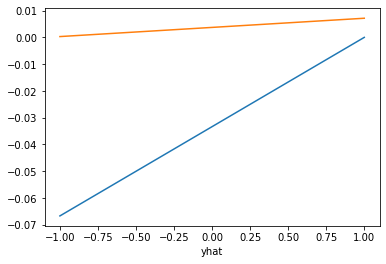

In [217]:
if __name__ == "__main__":
    # set args
    in_fp           = '../1-data/clean/bars_ethbtc_2d.pkl'
    cv_out_fp       = '../3-output/cv_results'
    freq            = 2880
    lhs_col         = 'y_ethbtc_r_tp5_tp' + str(freq+5)
    val_start_date  = '2021-10-01'
    val_end_date    = '2022-06-30'
    test_start_date = '2022-07-01'
    test_end_date   = '2022-12-31'
    num_cpus        = 20 # do factor of 4

    # read in and prep training+validation data
    df = pd.read_pickle(in_fp)
    df = df.set_index('date')
    df = df.astype('float32')
    
    # run the cv
    cv_results = runCV(df[:val_end_date],
        lhs_col=lhs_col,
        val_start_date=val_start_date,
        num_cpus=num_cpus,
        arch_name='rf_binary_2d',
        out_csv_fp=cv_out_fp)

    # select optimal optimal
    opt_model_dict = selectOptimalBacktestedModel(cv_results, df, start_date=val_start_date, end_date=val_end_date, lhs_col=lhs_col)

    # confirm stat sig
    reportBootstrapTstat(yhats=opt_model_dict['yhats']*opt_model_dict['lev'],
        y_real=df[val_start_date:val_end_date][lhs_col].values,
        possible_positions=[-5, -4, -3, -2, -1, -0.75, 0.5, 0.25, 0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5])

    # predict for the test period
    print('\n\n Test period results!! \n')
    del opt_model_dict['yhats']
    test_yhats = predictTestPeriod(df, lhs_col, 
        test_start_date, test_end_date, 
        opt_model_dict, num_cpus)

    # report test period results
    test_yhats  = test_yhats*opt_model_dict['lev']
    test_y_real = df[test_start_date:test_end_date][lhs_col].values
    reportTestPeriodResults(yhats=test_yhats,
                            y_real=test_y_real)
    reportBootstrapTstat(yhats=test_yhats, y_real=test_y_real,
        possible_positions=[-5, -4, -3, -2, -1, -0.75, 0.5, 0.25, 0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5])


In [405]:
# DRAFT CODE BELOW FOR STOP LOSS

# obtain validation period returns and positions
y_df = df[val_start_date:val_end_date][[lhs_col]]
y_df['yhats'] = opt_model_dict['yhats']*opt_model_dict['lev']

# pull in minute level data
min_df = pd.read_pickle('../1-data/clean/panel_ethbtc_1min.pkl')

# form minute level return 
min_df['y_1min'] = min_df.price.pct_change()

# cut down min df to window that i have
min_df = min_df[min_df.date >= np.min(y_df.index)]
min_df = min_df.set_index('date')
min_df = min_df[:'2022-06-30']
min_df = min_df.reset_index()

# drop cols and reset index
min_df = min_df[['date', 'y_1min']].reset_index(drop=True)
y_df = y_df.reset_index()

# merge data together
y_df = y_df.merge(min_df,
    on='date',
    how='outer',
    validate='one_to_one')
y_df = y_df.sort_values(by='date', ignore_index=True)

# calc portfolio returns for no stop loss
val_df = y_df[((y_df.date.dt.hour % 14) == 0) & ((y_df.date.dt.minute % 60) == 0)]
val_df = val_df.reset_index(drop=True)
yhats  = val_df.yhats.values[:-1]
y_real = val_df[lhs_col].values[:-1]
tc = calcTransactionCosts(yhats)
returns = yhats*y_real - tc
geom_mean = calcGeomAvg(returns)
sharpe    = calcSharpe(returns, periods_in_year=int(365/2))
print(f"geom mean: {geom_mean:.6f}")
print(f"sharpe: {sharpe:.2f}")

# loop over possible thresholds
for threshold in [-0.005, -0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08, -0.09, -0.1]:
    print(f"\n threshold is {threshold}")

    # initialize array of returns to calc
    y_real = []
    count = 0
    count_helpful = 0
    total_help      = 0

    # loop over every trading window
    for start_index in range(0, y_df.shape[0]-120, 120):
        # calc end index for this trading window
        end_index = start_index+130 

        # extract position
        position = y_df[start_index:start_index+1].yhats.values[0]

        # calc the cum ret over the window from five min post 2 hours to 130 min post 2 hours
        cum_ret = np.cumprod(1+y_df[start_index+6:end_index+1].y_1min.values)-1

        # if position is to be negative then flip returns
        if position < 0:
            cum_ret *= -1
        
        # if position is to not trade then set return to 0
        if position == 0:
            y_real.append(0)
        else: # figure out stop loss if it comes in play
            stop_loss = np.where(cum_ret<threshold)[0]
            if len(stop_loss) == 0:
                y_real.append(cum_ret[-1])
            else:
                index = np.min(stop_loss)
                if index == 124:
                    y_real.append(cum_ret[index])
                else:
                    y_real.append(cum_ret[index+1]) 
                    count += 1
                    if cum_ret[index+1] > cum_ret[124]:
                        count_helpful += 1
                        total_help += cum_ret[index+1] - cum_ret[124]

    returns = np.abs(yhats)*y_real - tc
    geom_mean = calcGeomAvg(returns)
    sharpe    = calcSharpe(returns, periods_in_year=365*12)
    print(f"geom mean: {geom_mean:.6f}")
    print(f"sharpe: {sharpe:.2f}") 
    print(f"count of num of trading windows where stop loss executed: {count}")
    print(f"count of num of trading windows where stop loss helped: {count_helpful}")
    if count_helpful > 0:
        print(f"arthimetic avg of how much stop loss helped conditional on helping: {total_help/count_helpful:.6f}")



 threshold is -0.005
geom mean: 0.000004
sharpe: 0.41
count of num of trading windows where stop loss executed: 139
count of num of trading windows where stop loss helped: 58
arthimetic avg of how much stop loss helped conditional on helping: 0.005506

 threshold is -0.01
geom mean: 0.000117
sharpe: 1.00
count of num of trading windows where stop loss executed: 63
count of num of trading windows where stop loss helped: 21
arthimetic avg of how much stop loss helped conditional on helping: 0.006237

 threshold is -0.02
geom mean: 0.000211
sharpe: 1.42
count of num of trading windows where stop loss executed: 16
count of num of trading windows where stop loss helped: 6
arthimetic avg of how much stop loss helped conditional on helping: 0.005621

 threshold is -0.03
geom mean: 0.000254
sharpe: 1.59
count of num of trading windows where stop loss executed: 4
count of num of trading windows where stop loss helped: 0

 threshold is -0.04
geom mean: 0.000316
sharpe: 1.87
count of num of trad